In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ezephys.stimtools as st

# Types of stimuli

- `SimpleStimulus`
    - `SinStimulus`: Sine wave.
    - `ChirpStimulus`: Sine wave of increasing or decreasing frequency.
    - `OUStimulus`: Ornstein-Uhlenbeck noise, a model of synaptic noise.
- `StepStimulus`: Square current steps.
- `ConvolvedStimulus`: Kernel convolved with an indicator vector.

- `CompoundStimulus`: Stimuli can be concatenated or added together to form a `CompoundStimulus`.

# `StepStimulus`

Probably the most common type of stimulus in electrophysiological experiments. `StepStimulus` objects are initialized by passing a series of step durations and amplitudes.

In [2]:
step_stim = st.StepStimulus(durations=[200., 1e3, 700.], amplitudes=[3., 40., 0.], dt=0.1)

Note: In `ezephys`, time is always in milliseconds.

In [3]:
print(step_stim.command)

[3. 3. 3. ... 0. 0. 0.]


The step simulus is available as a regular numpy array stored in the `command` attribute.

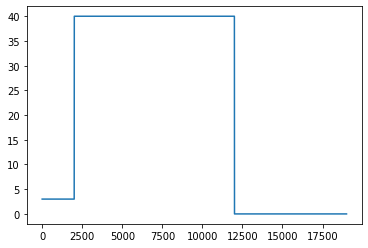

In [4]:
plt.plot(step_stim.command)

You can plot the `command` attribute if you like, but there are better ways to inspect stimuli that we'll cover soon.

# `SimpleStimulus`

Simple stimuli are classes that inherit from the `SimpleStimulus` abstract class.

In [5]:
duration = 5e3  # 5s

sinewave = st.SinStimulus(mean=0, amplitude=5, frequency=0.5, duration=duration)
chirp = st.ChirpStimulus(mean=0, amplitude=10, initial_frequency=1, final_frequency=20, duration=duration)
noise = st.OUStimulus(mean=0, amplitude=1, tau=5, ampli_modulation=0.5, mod_period=200, seed=42, duration=duration)

## Inspecting stimuli

Stimtools provides two ways to inspect stimulus objects after they are created: textually as a recipe, and visually as a plot.

### Recipe

In [6]:
sinewave

ez.stimtools.SinStimulus(mean=0, amplitude=5, frequency=0.5, label=None)

If you've `import`ed `ezephys as ez`, the recipe is valid python code that you can use to generate an exact copy of the stimulus.

### Plot

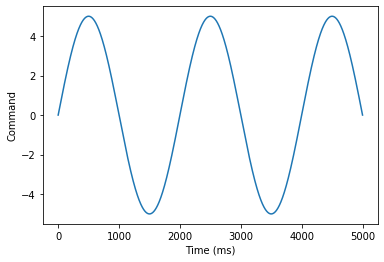

In [7]:
sinewave.plot()

## Customizing stimulus plots

Plots integrate seamlessly with matplotlib, allowing them to be customized using familiar syntax. (See `matplotlib.pyplot.plot` documentation for valid formatting parameters.)

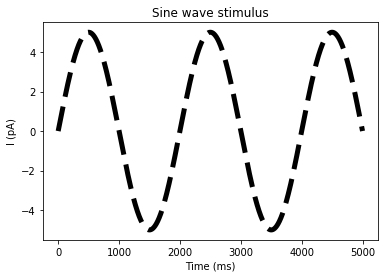

In [8]:
sinewave.plot(color='k', linewidth=5, linestyle='--', dashes=(5, 2))
plt.ylabel('I (pA)')
plt.title('Sine wave stimulus')

plt.show()

Plots can be inserted into specific panels of a matplotlib figure using the optional `ax` argument.

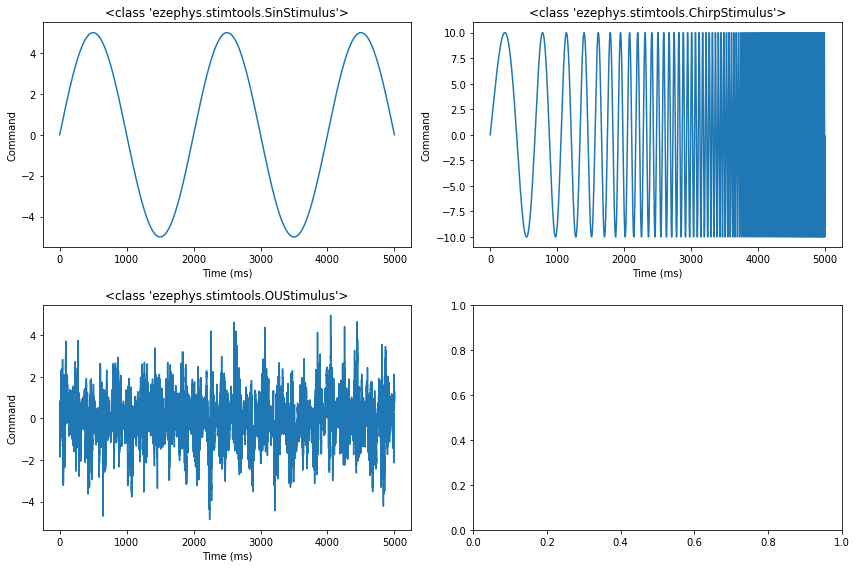

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten().tolist()

for ax, stim in zip(axes, [sinewave, chirp, noise]):
    ax.set_title(type(stim))
    stim.plot(ax=ax)  # Send plot to a specific matplotlib.axes object.

plt.tight_layout()
plt.show()

# Synaptic trains: `ConvolvedStimulus`

Synaptic trains can be modelled as a stereotyped synaptic current (or `kernel`) convolved with a set of trigger events (or `basis`). `stimtools` supports all types of convolved stimuli, including synaptic trains, via its `ConvolvedStimulus` class.

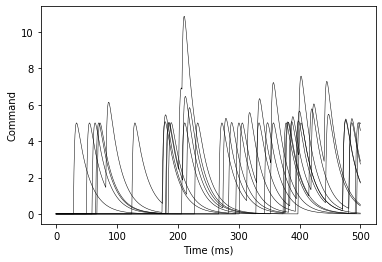

In [10]:
no_sweeps = 10
syntrain = st.ConvolvedStimulus(
    loc=0, 
    kernel=st.BiexponentialSynapticKernel(5, 2, 20), 
    basis=np.random.uniform(size=(no_sweeps, 5000)) < 0.001  # Sample a Poisson process to trigger synaptic events
)
syntrain.plot(color='k', lw=0.5)

In the example above we manually whipped up a Poisson process to serve as a trigger for synaptic currents, but this is a bit cumbersome. The `PoissonProcess` class below provides a more convenient and explicit interface for using a Poisson process to drive convolved stimuli.

## Stochastic synaptic trains using `PoissonProcess`

`PoissonProcess` is initialized with a `rate`, which can be a stimulus object, and time step size `dt`.

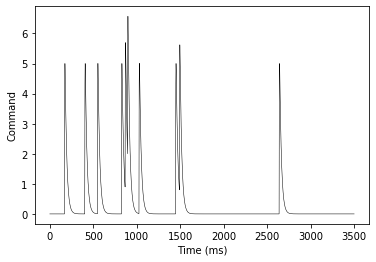

In [11]:
rate = st.StepStimulus([500., 1000., 2000.], [2., 6., 0.1])
process = st.PoissonProcess(rate)
process.sample()

stochastic_syntrain = st.ConvolvedStimulus(0, st.BiexponentialSynapticKernel(5, 2, 20), process.sample())
stochastic_syntrain.plot(color='k', lw=0.5)

## Stochastic synaptic bursts

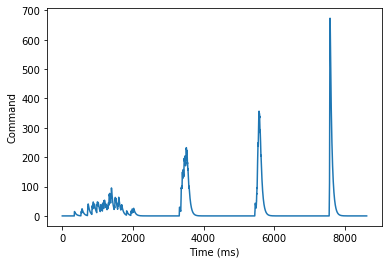

In [12]:
padding = st.StepStimulus([250.], [0.])

synaptic_bursts = [padding]
for jitter, post_sigma in zip([500, 100, 50, 10], [4, 20, 40, 80]):
    synaptic_trigger = st.DiscreteJitteredEvent(jitter)

    synaptic_bursts.append(
        st.ConvolvedStimulus(
            0, 
            st.BiexponentialSynapticKernel(15, 2, 50), 
            synaptic_trigger.sample(50, (2, post_sigma)).sum(axis=0)
        )
    )

synaptic_bursts.append(padding)
synaptic_bursts = st.concatenate(synaptic_bursts)
synaptic_bursts.plot()

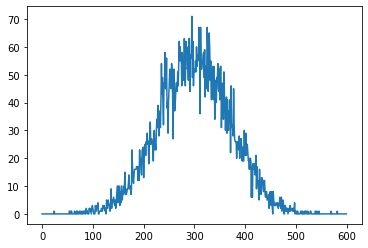

In [13]:
plt.plot(synaptic_trigger.sample(10000, (3, 3)).sum(axis=0))

`DiscreteJitteredEvent`s follow an approximately normal distribution.

# Assembling complicated stimuli: `CompoundStimulus`

Stimuli can be added together, yielding a `CompoundStimulus`.

In [14]:
compound = (
    stochastic_syntrain 
    + st.OUStimulus(0, 0.5, 2., 0., 0., duration=stochastic_syntrain.duration, dt=stochastic_syntrain.dt)
)
compound

In [15]:
print(compound)

ez.stimtools.ConvolvedStimulus(loc=0, kernel=ez.stimtools.BiexponentialSynapticKernel(size=5, tau_rise=2, tau_decay=20, size_method=amplitude, label=None), basis=<ezephys.stimtools.ArrayStimulus object at 0x1a2521c050>, dt=0.1, label=None)
+ ez.stimtools.OUStimulus(mean=0, amplitude=0.5, tau=2.0, ampli_modulation=0.0, mod_period=0.0, seed=None, label=None)


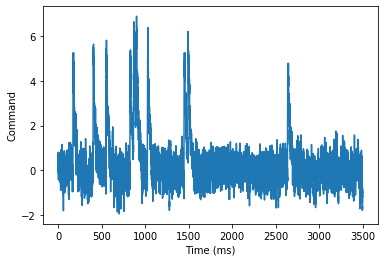

In [16]:
compound.plot()

In [17]:
compound.command

array([[ 0.        ,  0.13745849,  0.45856456, ..., -1.19532103,
        -0.98801991, -0.76180476]])

`Stimulus` and array-like objects can be added together and concatenated to construct arbitrary stimuli.

concatenate(
	ez.stimtools.SinStimulus(mean=0, amplitude=5, frequency=0.5, label=None)
	+ array_like,
	array_like,
	ez.stimtools.ConvolvedStimulus(loc=0, kernel=ez.stimtools.BiexponentialSynapticKernel(size=5, tau_rise=2, tau_decay=20, size_method=amplitude, label=None), basis=<ezephys.stimtools.ArrayStimulus object at 0x1a2521c050>, dt=0.1, label=None)
	+ ez.stimtools.OUStimulus(mean=0, amplitude=0.5, tau=2.0, ampli_modulation=0.0, mod_period=0.0, seed=None, label=None)
	+ array_like,
	array_like
)


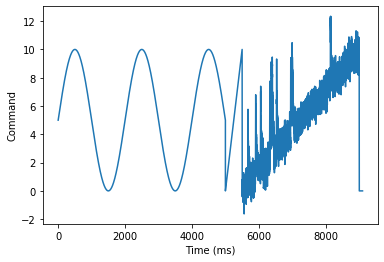

In [18]:
concat_compound = st.concatenate([
    sinewave + 5,
    np.linspace(0, 10, 5000),
    compound + np.linspace(0, 10, compound.no_timesteps), 
    [0 for i in range(1000)]
])

print(concat_compound)
concat_compound.plot()

# Additional stimulus types

ez.stimtools.SquareWaveStimulus(mean=2, amplitude=-5, frequency=2, label=None)

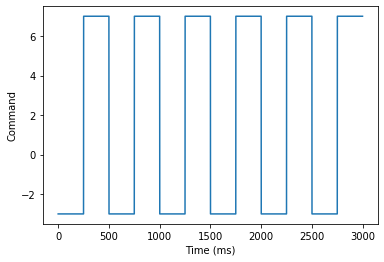

In [19]:
square_wave = st.SquareWaveStimulus(2, -5, 2, 2999.05, dt=0.1)
square_wave.plot()
square_wave

ez.stimtools.CosStimulus(mean=2, amplitude=-5, frequency=2.0, label=None)

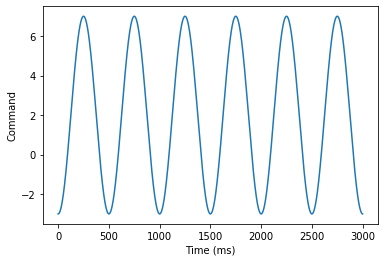

In [20]:
cos_wave = st.CosStimulus(2, -5, 2., 2999.05, dt=0.1)
cos_wave.plot()
cos_wave